![image.png](https://i.imgur.com/a3uAqnb.png)

# Image Classification using CNN: CIFAR10
- **Images**: 60,000 color images of size **(32x32)** in **10 categories**, with 6000 images per class. There are 50000 training images and 10000 test images.
- **Classes**: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.
- **Shape**: `(batch_size, 3, 32, 32)` → 3 channels (RGB).
  
![CIFAR-10 image](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)


## 1️⃣ Dataset Class

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Define transformations (convert to tensor)                         ## Will study in-depth in a next lab
transform = transforms.Compose([
    transforms.ToTensor(),    # scale pixile to the range [0,255] to range between [ 0.0 , 1.0 ] :; normalization
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = CIFAR10(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders
# (The Dataset Class loads only one sample at a time. We pass it to dataloader to read batch_size of images at a time)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) # # pre-proccer in batch one train on it
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check dataset size
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training samples: 50000, Testing samples: 10000


### Let's display some images

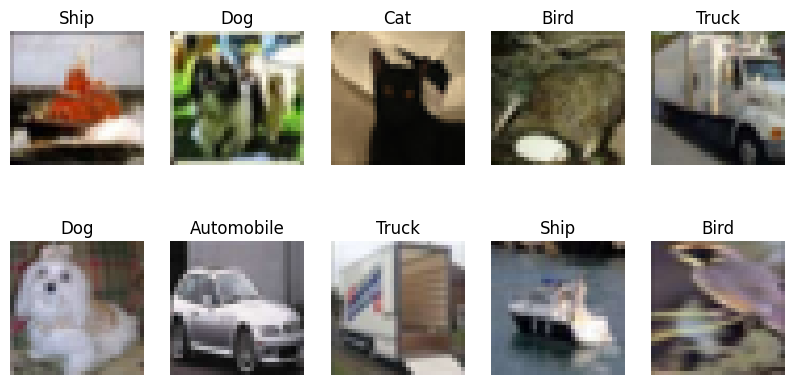

Shape of one image tensor: torch.Size([3, 32, 32])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# CIFAR-10 class names
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Show images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i]
    img = np.transpose(img.numpy(), (1, 2, 0))  # Convert (C, H, W) to (H, W, C) حولناه من قبل تينسور الحينن رجعه الا صوره بس عكسها الانهم عكس بعض

    ax.imshow(img)
    ax.set_title(classes[labels[i].item()])
    ax.axis("off")

plt.show()

# Show shape of one image
print("Shape of one image tensor:", images[0].shape)  # Expected: (3, 32, 32)


## 2️⃣ Model Class

In [ ]:
import torch.nn as nn
import torch

# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Activation
        self.relu = nn.ReLU()

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for CIFAR-10

    def forward(self, x):
        # Convolution + ReLU + Pooling
        x = self.pool(self.relu(self.conv1(x)))  # (Batch, 16, 16, 16)
        x = self.pool(self.relu(self.conv2(x)))  # (Batch, 32, 8, 8)
        x = self.pool(self.relu(self.conv3(x)))  # (Batch, 64, 4, 4)

        # Flatten
        x = x.view(x.size(0), -1)  # (Batch, 64*4*4) re-shape the same as fully connected

        # Fully Connected Layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Logitsic

        return x  # Although this is a classification problem, we didn't apply softmax. Do you know why?👀 (Hint: CrossEntropyLoss has something to do here👀)

## 3️⃣ Training and Validation Loops

In [ ]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode, behavior of activation and loss is diff from train to evalute so we need to set it since they have similar codes
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item() # نتاكد من برديكشن هل هو صح
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy



# 🔹 Validation Loop

def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy


## 4️⃣ Running Training

In [ ]:
import torch.optim as optim

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 20 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 1563/1563 [00:12<00:00, 123.90it/s]


Epoch 1/20: Train Loss=1.5518, Train Accuracy=43.42%, Val Loss=1.2337, Val Accuracy=55.14%


100%|██████████| 1563/1563 [00:12<00:00, 124.88it/s]


Epoch 2/20: Train Loss=1.1773, Train Accuracy=58.08%, Val Loss=1.0913, Val Accuracy=61.21%


100%|██████████| 1563/1563 [00:12<00:00, 121.48it/s]


Epoch 3/20: Train Loss=1.0144, Train Accuracy=64.33%, Val Loss=1.0115, Val Accuracy=64.77%


100%|██████████| 1563/1563 [00:12<00:00, 123.95it/s]


Epoch 4/20: Train Loss=0.9045, Train Accuracy=68.42%, Val Loss=0.9168, Val Accuracy=67.88%


100%|██████████| 1563/1563 [00:12<00:00, 123.03it/s]


Epoch 5/20: Train Loss=0.8309, Train Accuracy=70.82%, Val Loss=0.8960, Val Accuracy=68.80%


100%|██████████| 1563/1563 [00:12<00:00, 124.64it/s]


Epoch 6/20: Train Loss=0.7661, Train Accuracy=73.10%, Val Loss=0.8720, Val Accuracy=70.35%


100%|██████████| 1563/1563 [00:13<00:00, 116.44it/s]


Epoch 7/20: Train Loss=0.7131, Train Accuracy=74.92%, Val Loss=0.8421, Val Accuracy=71.30%


100%|██████████| 1563/1563 [00:16<00:00, 96.20it/s] 


Epoch 8/20: Train Loss=0.6670, Train Accuracy=76.52%, Val Loss=0.8075, Val Accuracy=72.35%


100%|██████████| 1563/1563 [00:14<00:00, 107.34it/s]


Epoch 9/20: Train Loss=0.6300, Train Accuracy=77.96%, Val Loss=0.8877, Val Accuracy=69.77%


100%|██████████| 1563/1563 [00:12<00:00, 124.26it/s]


Epoch 10/20: Train Loss=0.5944, Train Accuracy=79.15%, Val Loss=0.8208, Val Accuracy=72.06%


100%|██████████| 1563/1563 [00:12<00:00, 125.23it/s]


Epoch 11/20: Train Loss=0.5618, Train Accuracy=80.00%, Val Loss=0.8579, Val Accuracy=72.06%


100%|██████████| 1563/1563 [00:12<00:00, 123.95it/s]


Epoch 12/20: Train Loss=0.5294, Train Accuracy=81.32%, Val Loss=0.8638, Val Accuracy=72.04%


100%|██████████| 1563/1563 [00:12<00:00, 124.85it/s]


Epoch 13/20: Train Loss=0.5002, Train Accuracy=82.14%, Val Loss=0.9491, Val Accuracy=70.07%


100%|██████████| 1563/1563 [00:12<00:00, 123.03it/s]


Epoch 14/20: Train Loss=0.4680, Train Accuracy=83.26%, Val Loss=0.8745, Val Accuracy=72.15%


100%|██████████| 1563/1563 [00:13<00:00, 117.86it/s]


Epoch 15/20: Train Loss=0.4430, Train Accuracy=84.13%, Val Loss=0.9279, Val Accuracy=71.30%


100%|██████████| 1563/1563 [00:12<00:00, 123.77it/s]


Epoch 16/20: Train Loss=0.4167, Train Accuracy=85.07%, Val Loss=0.9708, Val Accuracy=71.05%


100%|██████████| 1563/1563 [00:12<00:00, 125.28it/s]


Epoch 17/20: Train Loss=0.3939, Train Accuracy=85.77%, Val Loss=0.9731, Val Accuracy=72.17%


100%|██████████| 1563/1563 [00:13<00:00, 114.56it/s]


Epoch 18/20: Train Loss=0.3685, Train Accuracy=86.67%, Val Loss=1.0373, Val Accuracy=71.74%


100%|██████████| 1563/1563 [00:12<00:00, 122.63it/s]


Epoch 19/20: Train Loss=0.3471, Train Accuracy=87.35%, Val Loss=1.0922, Val Accuracy=71.19%


100%|██████████| 1563/1563 [00:12<00:00, 124.31it/s]


Epoch 20/20: Train Loss=0.3313, Train Accuracy=88.16%, Val Loss=1.1282, Val Accuracy=70.21%


### Plot loss and some predictions

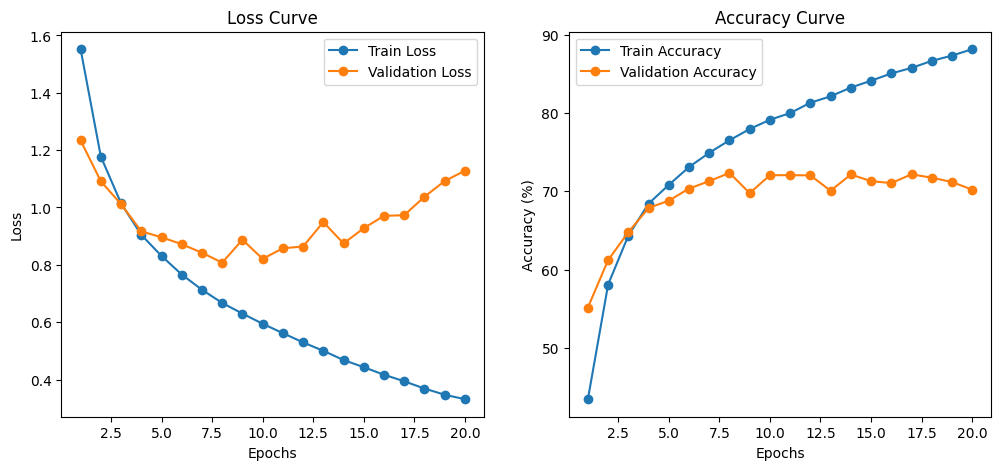

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


# في لوس في 7 بدء يصير اوفر فيت المودل حافظ مو فاهم
# نحسن الموضوع ب using , dropots ( drop neurons that have loss ) , regulaization , early stopping , data augmentation ( increase dataset )


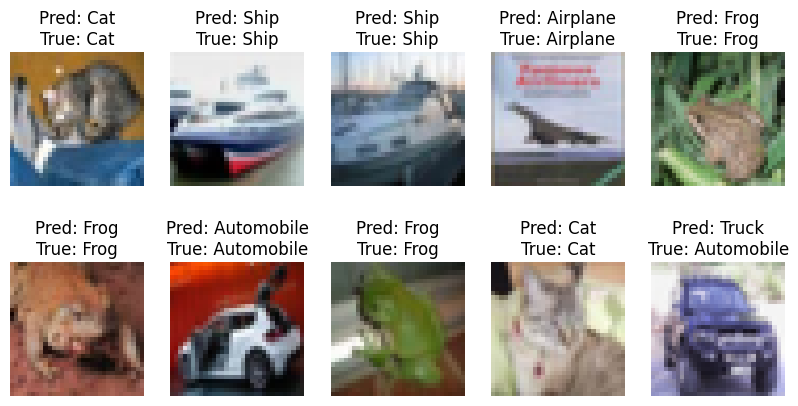

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images with predicted labels
def show_predictions(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(images)
        predictions = outputs.argmax(dim=1)  # Get predicted class

    # CIFAR-10 class names
    classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat[:num_images]):
        img = images[i]
        img = np.transpose(img.cpu().numpy(), (1, 2, 0))  # Convert to (H, W, C)

        ax.imshow(img)
        ax.set_title(f"Pred: {classes[predictions[i].item()]}\nTrue: {classes[labels[i].item()]}")
        ax.axis("off")

    plt.show()

# Show predictions
show_predictions(model, test_loader, device)


### Contributed by: Mohamed Eltayeb

![image.png](https://i.imgur.com/a3uAqnb.png)